In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv('/kaggle/input/pothole-rainflip-aml-final/new data/train_ids_rainflip_labels.csv')

In [3]:
train.shape

(4696, 2)

In [4]:
# use sklearn train_test_split to ensure stratified split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['Image_ID'].values,
                                                    train['Label'].values,
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=train['Label'].values)

In [5]:
# to build tf train set and test set
# the csv's are handy to calculate the loss of each instance
train_df = pd.DataFrame({'Image_ID': X_train, 'Label': y_train})
test_df = pd.DataFrame({'Image_ID': X_test, 'Label': y_test})
train_df.to_csv('new_train_id_labels.csv', index=False)
test_df.to_csv('test_id_labels.csv', index=False)

In [6]:
import matplotlib.pylab as plt
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3

In [7]:
import tensorflow as tf
def read_and_decode(filename, reshape_dims):
    # 1. Read the file.
    img = tf.io.read_file(filename)
    # 2. Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=3)
    # 3. Convert 3D uint8 in the range of [0,255] to floats in the [0,1] range.
    #   img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

2024-03-30 10:16:43.784957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 10:16:43.785055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 10:16:43.949972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
# decode function to read csv to build tf datasets
def decode_csv(csv_row):
    record_defaults = ["path", int()]
    filename, label = tf.io.decode_csv(csv_row, record_defaults)
    filename = '/kaggle/input/pothole-rainflip-aml-final/new data/all_data/all_data/'+ filename +'.JPG'
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    # label = tf.math.equal(CLASS_NAMES, label_string)
    return img, label

In [9]:
# build tf datasets
dataset = (tf.data.TextLineDataset('/kaggle/working/new_train_id_labels.csv').skip(1). #skip(1) to skip header
map(decode_csv)) # train set
test_dataset = (tf.data.TextLineDataset('/kaggle/working/test_id_labels.csv').skip(1). #skip(1) to skip header
map(decode_csv)).batch(8) # test set

In [10]:
train_size = int(0.8 * train_df.shape[0])
# val_size = int(0.2 * train_df.shape[0])

dataset = dataset.shuffle(buffer_size=train_df.shape[0])
train_dataset = dataset.take(train_size).batch(8)
val_dataset = dataset.skip(train_size).batch(8)
# preprocess the datasets: convert input format from [0,255] to the format expected by MobileNetV2
preprocess_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.mobilenet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*[IMG_HEIGHT, IMG_WIDTH], 3])

train_dataset.map(lambda x,y: (preprocess_layer(x), y))
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset.map(lambda x, y: (preprocess_layer(x),y))
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset.map(lambda x, y: (preprocess_layer(x),y))
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/lambda_layer.py:67: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# build model
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[*[IMG_HEIGHT, IMG_WIDTH], 3])
pretrained_model.trainable= True

x = tf.keras.layers.GlobalAveragePooling2D()(pretrained_model.output)
x = tf.keras.layers.Dense(16, activation='relu', name='pothole_dense')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='pothole_prob')(x)

model = tf.keras.models.Model(pretrained_model.input,outputs)

model.compile(
    optimizer='adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,278,497 (8.69 MB)

 Trainable params: 2,244,385 (8.56 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [12]:
# Custom learning rate scheduler function
lr_start   = 1e-4
lr_max     = 0.000015
lr_min     = 1e-7
lr_ramp_ep = 3
lr_sus_ep  = 0
lr_decay   = 0.7
   
def lrfn(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start            
    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
    return lr

# Using this Custom Function, create a Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [13]:
# model training
history = model.fit(train_dataset, epochs=10,
                    validation_data=val_dataset,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3), lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/10
      3/Unknown 62s 53ms/step - accuracy: 0.3750 - loss: 0.7283

I0000 00:00:1711794333.228341     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711794333.286702     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


    399/Unknown 75s 33ms/step - accuracy: 0.8059 - loss: 0.4015

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1711794354.753334     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


399/399 ━━━━━━━━━━━━━━━━━━━━ 88s 67ms/step - accuracy: 0.8061 - loss: 0.4013 - val_accuracy: 0.8486 - val_loss: 0.3332 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 7.166666666666667e-05.
Epoch 2/10


W0000 00:00:1711794359.841786     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


399/399 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.9390 - loss: 0.1465 - val_accuracy: 0.9599 - val_loss: 0.1370 - learning_rate: 7.1667e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.3333333333333334e-05.
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9764 - loss: 0.0770 - val_accuracy: 0.9937 - val_loss: 0.0205 - learning_rate: 4.3333e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.5e-05.
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.9861 - loss: 0.0475 - val_accuracy: 0.9912 - val_loss: 0.0174 - learning_rate: 1.5000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.0529999999999999e-05.
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.9918 - loss: 0.0319 - val_accuracy: 0.9987 - val_loss: 0.0057 - learning_rate: 1.0530e-05

Epoch 6: LearningRateScheduler setting learning rate to 7.400999999999999e-06.
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.995

In [14]:
# evaluate on the test set
results = model.evaluate(test_dataset)

89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9815 - loss: 0.0627


In [15]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [16]:
from IPython.display import Image, display
import matplotlib as mpl
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [17]:
last_conv_layer_name = 'Conv_1'

In [18]:
# Remove last layer's activation function (sigmoid)
model.layers[-1].activation = None

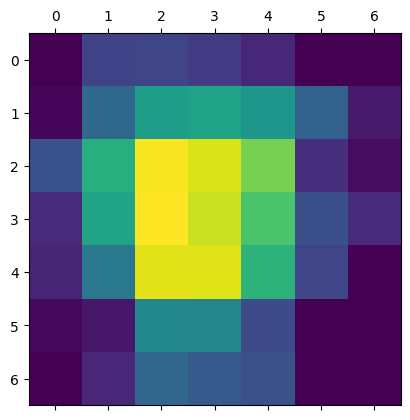

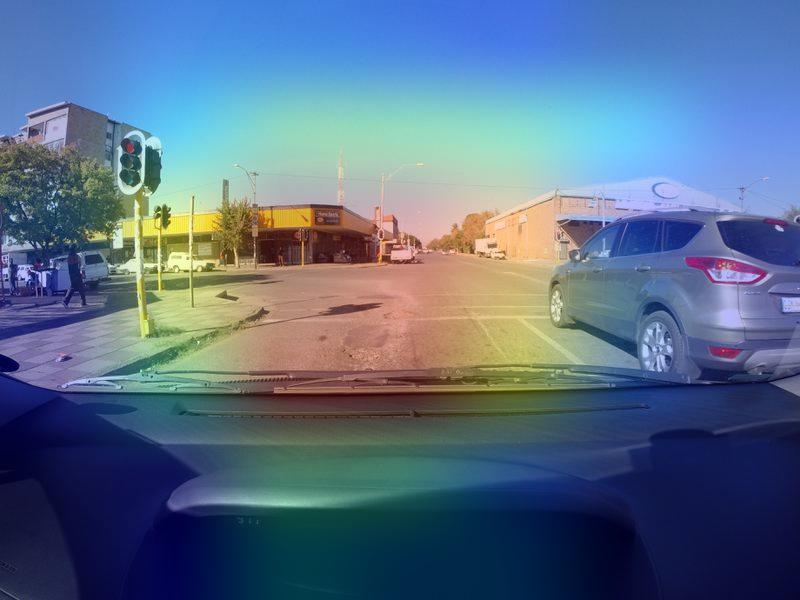

In [34]:
# test the grad cam 
img_path = '/kaggle/input/pothole-rainflip-aml-final/new data/all_data/all_data/jOsYoCYLRmnFmNm.JPG'
img = read_and_decode(img_path, [IMG_HEIGHT, IMG_WIDTH])
doc = tf.expand_dims(img, axis=0)
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(doc, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img_path, heatmap)

In [20]:
def gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    return superimposed_img

In [35]:
filenames = ['pQVbGRebTAwmTnv','shRYejQmoIcPXFW','jOsYoCYLRmnFmNm','liCaWxHAhHpFsrz','GgbTBjlZpzCTLSo','HdyRyKBWYuJPgyG','OtentfnkpKSXBOu',
'ndJbsOThuKwfYmu','twvydkkKycsdAvn','BOrVotINGylbEGK','LOoadBMcPPPiGfA','KNjXjRYyYbABKRv','waMCvfGJarKfTJF','kOSfAJBhBylzeBu','tjEpnRouMRxTeqX']

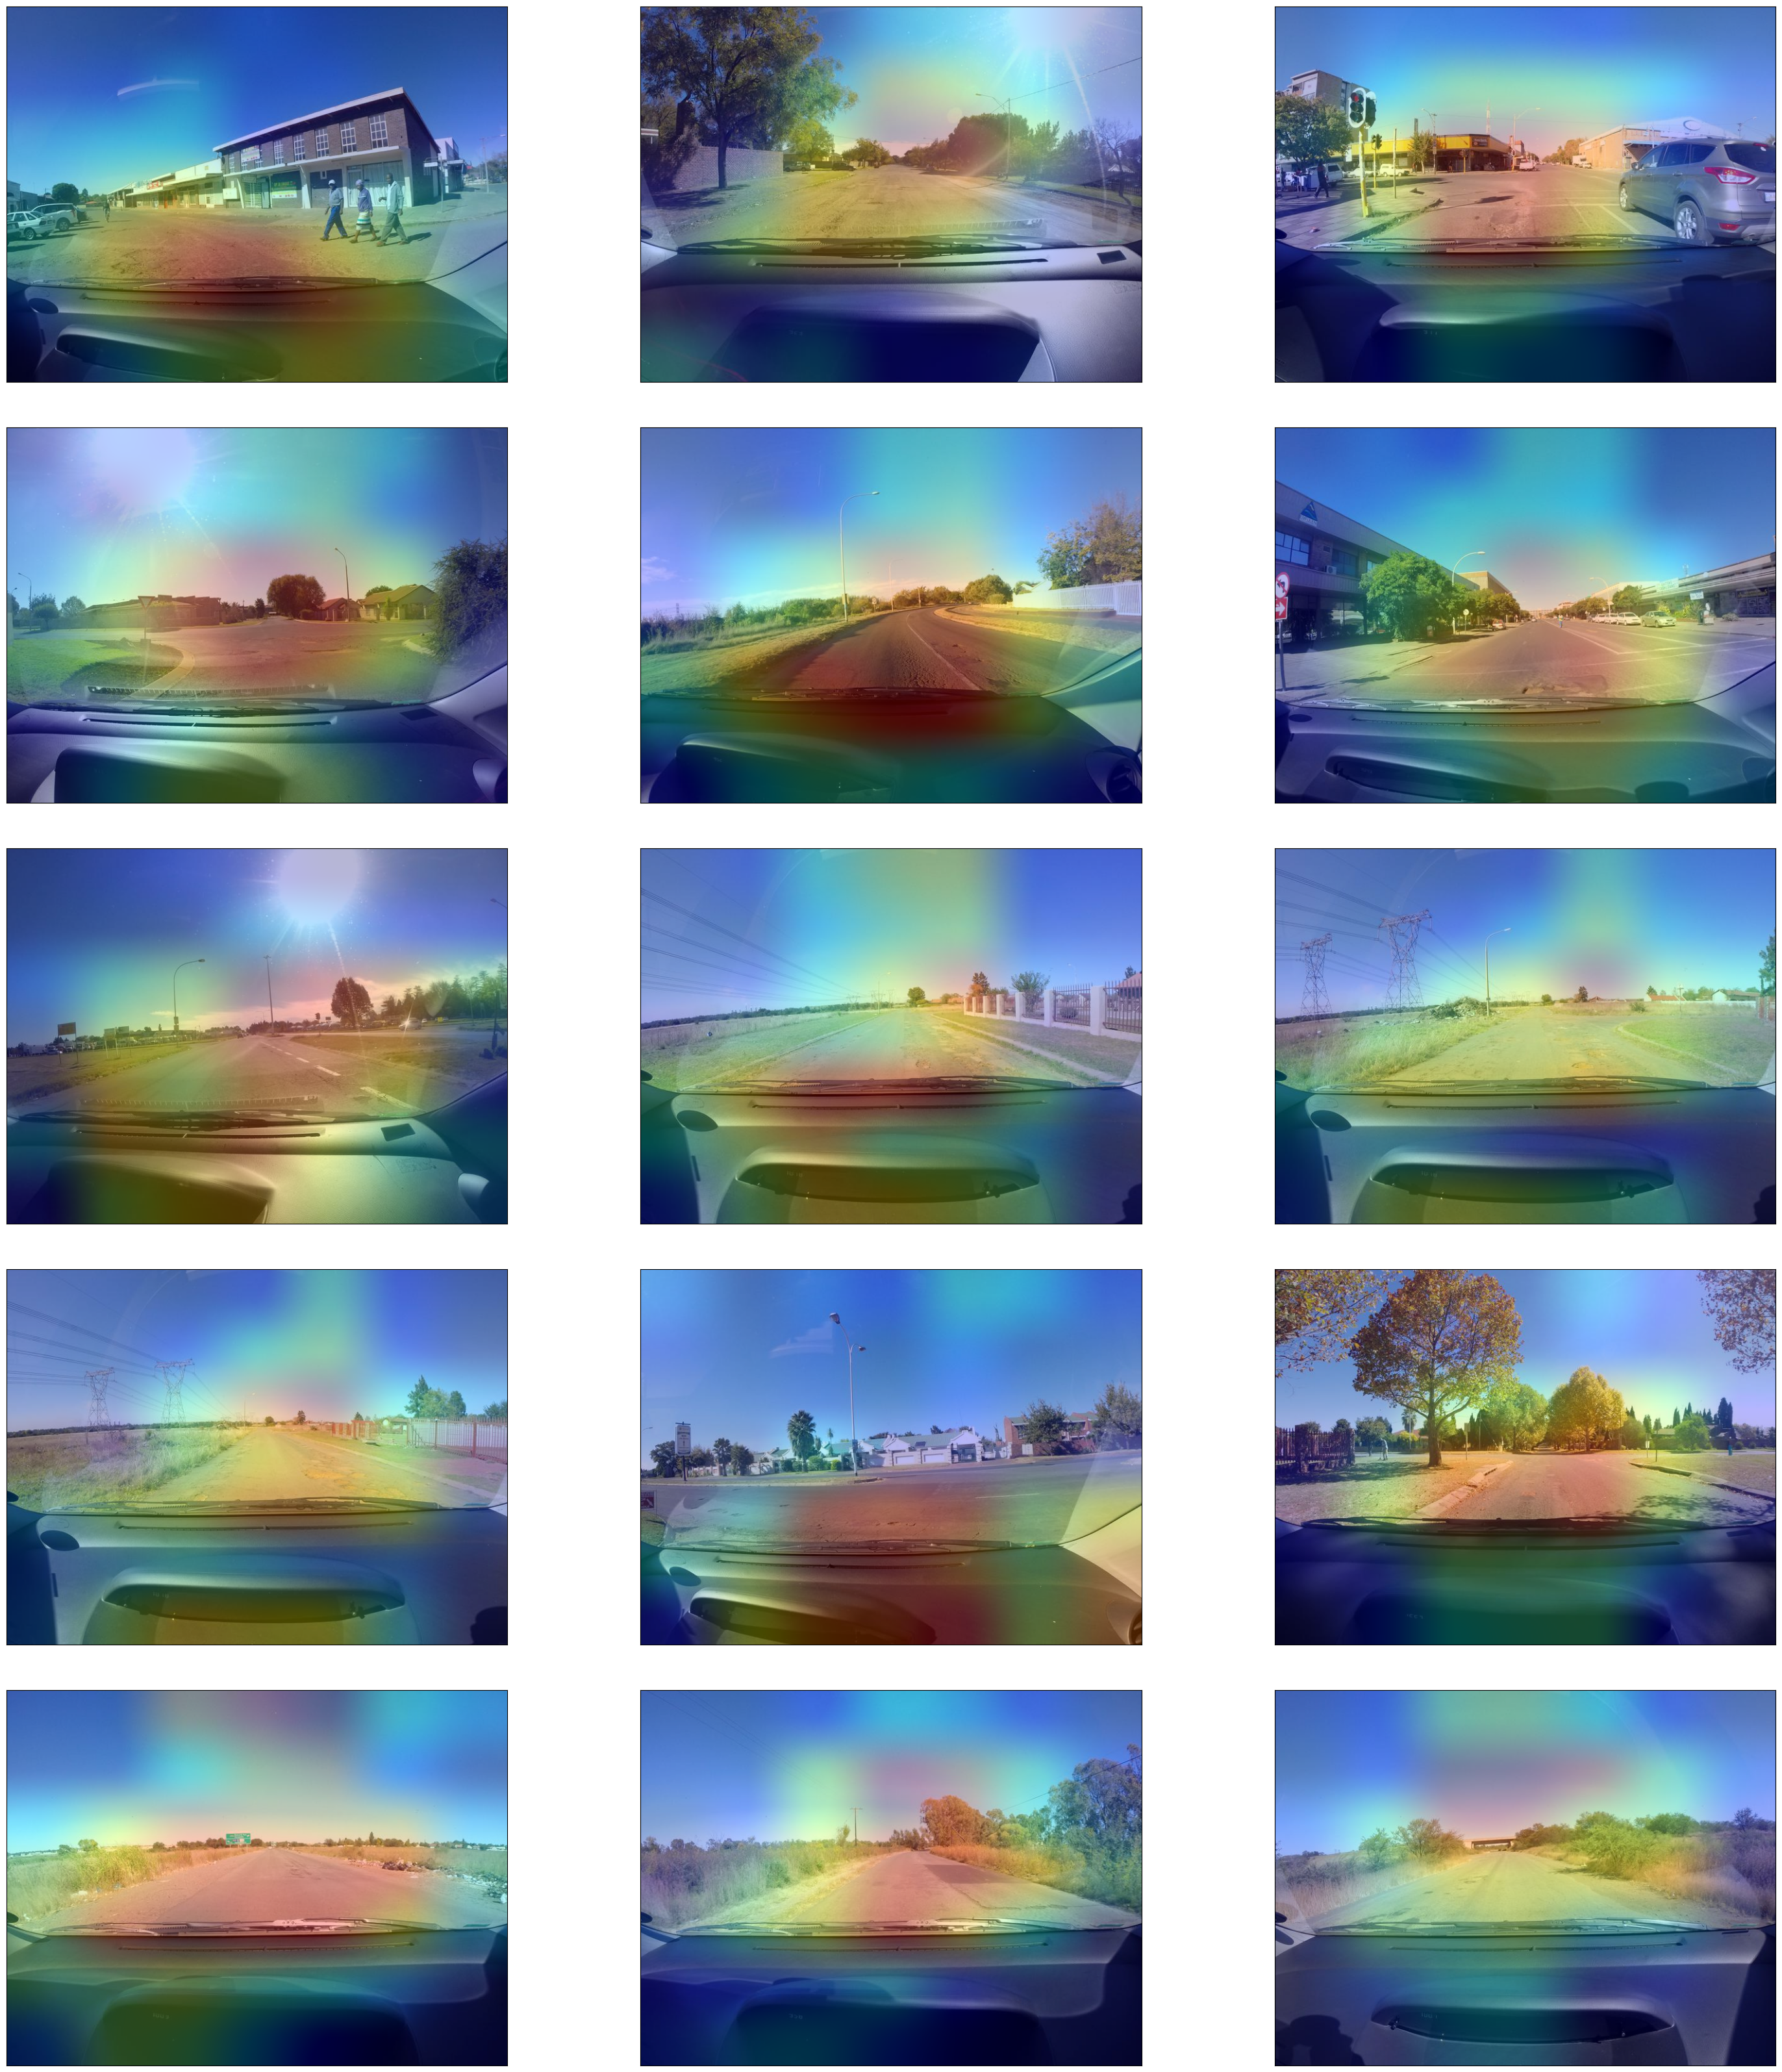

In [36]:
fig, axs = plt.subplots(5, 3, figsize=(32, 32), sharey=True)
axs = axs.flatten()
for i in range(15):
    img_path = '/kaggle/input/pothole-rainflip-aml-final/new data/all_data/all_data/'+filenames[i]+'.JPG'
    img = read_and_decode(img_path, [IMG_HEIGHT, IMG_WIDTH])
    doc = tf.expand_dims(img, axis=0)
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(doc, model, last_conv_layer_name)
    img_cam = gradcam(img_path,heatmap)
    axs[i].imshow(img_cam)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].grid(False)
    fig.tight_layout(h_pad=5, w_pad=5)